이 프로젝트는 UCI에서 제공하는 Auto MPG 데이터셋을 사용하여 자동차의 연비(MPG)를 예측하는 인공신경망 모델입니다.  

- 알고리즘: 다층 퍼셉트론(MLP, Multi-Layer Perceptron)  
- 데이터 전처리: 결측치 제거, 원-핫 인코딩, 정규화
- 결과: 평균 제곱 오차(MSE) = 6.69, 예측 오차 약 ±2.6 MPG

## 사용 자료: UCI Auto MPG 데이터셋
- 데이터셋 출처: [UCI 머신러닝 저장소](https://archive.ics.uci.edu/dataset/9/auto+mpg)
- 샘플 개수: 398개
- 특성(Feature):
MPG(연비): 최소값 9.0, 최대값 46.6, 평균 23.5
Cylinders(실린더 수): 최소값 3, 최대값 8, 평균 5.5
Displacement(배기량): 최소값 68.0, 최대값 455.0, 평균 194.4
Horsepower(마력): 최소값 46.0, 최대값 230.0, 평균 104.5
Weight(무게): 최소값 1613.0, 최대값 5140.0, 평균 2970.3
Acceleration(가속도): 최소값 8.0, 최대값 24.8, 평균 15.6
Model Year(제작 연도): 최소값 70, 최대값 82, 평균 76.0
Origin(원산지): 값은 1(미국), 2(유럽), 3(일본)

  타겟
MPG(연비): 최소값 9.0, 최대값 46.6, 평균 23.5



In [124]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

keras.utils.get_file를 사용해 데이터를 다운로드하고, pandas로 데이터프레임 형태로 불러왔습니다.
이 데이터에는 결측치가 포함되어 있으므로 이를 na_values로 처리했습니다.

In [125]:
dataset_path = keras.utils.get_file(
    "auto-mpg.data",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
)

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values="?", comment='\t',
                          sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()

dataset = dataset.dropna()로 결측치를 제거하거나 대체했습니다.

Origin 열은 차량의 원산지를 의미하며, 범주형 데이터이므로 원-핫 인코딩으로 변환했습니다.

In [126]:
dataset = dataset.dropna()

origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2) * 1.0
dataset['Japan'] = (origin == 3) * 1.0

데이터는 전체 데이터의 80%를 훈련 데이터, 나머지 20%를 테스트 데이터로 분할했습니다.
이렇게 나누는 이유는 모델이 훈련 데이터를 학습한 뒤, 테스트 데이터에서 예측 성능을 평가하기 위함입니다.

연비(MPG)는 예측 대상이므로 통계에서 제외했습니다(pop("MPG")).

In [127]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()

모델을 통해 예측하려는 대상은 자동차의 연비입니다. 훈련과 테스트 데이터에서 연비를 제거하고 저장합니다.

In [128]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

평균을 빼고, 표준편차로 나누는 방식으로 정규화를 진행합니다.

In [129]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

활성화 함수는 렐루를 사용합니다.

최적화 알고리즘: Adam 옵티마이저
   - 학습 속도와 안정성이 뛰어남
손실 함수: 평균 제곱 오차(MSE)
활성화 함수: Relu

은닉층 2개, 각 64개의 뉴런
데이터 크기(398개)와 특성 수(7개)에 비해 적절한 복잡성을 가짐.
은닉층 개수를 늘리면 학습 성능이 향상될 가능성이 있지만, 과적합 위험이 증가하므로 2개의 층을 선택.
출력층 1개
연비(MPG)를 예측하기 위한 단일 연속형 값 출력.

In [130]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(0.001)
    model.compile(
        loss='mse',
        optimizer=optimizer,
        metrics=['mse']
    )
    return model

model = build_model()

c:\Users\imman\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


모델 학습
에포크: 최대 1000, Early Stopping 적용
   - 과적합 방지를 위해 검증 손실 기준 조기 종료

In [131]:
EPOCHS = 1000
history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=0
)

평균제곱오차 그래프를 통해 반복이 200~300번이 넘어가면 테스트 데이터의 오차가 증가하여 과적합되는 것을 알 수 있습니다.

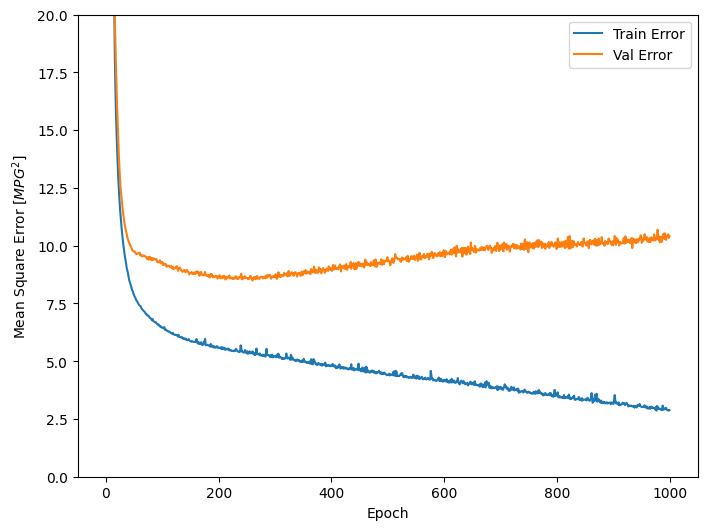

In [132]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8, 6))

    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
    plt.ylim([0, 20])
    plt.legend()
    plt.show()

plot_history(history)

테스트 데이터 업데이트를 감소하여 과적합을 방지합니다.

In [133]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2,
    verbose=0, callbacks=[early_stop]
)

학습된 모델을 테스트 데이터에 적용하여 최종 성능을 평가하는 부분입니다. 
6.69정도의 수치는 모델이 예측한 연비 값과 실제 값 간의 오차가 평균적으로 약 ±2.6 정도임을 의미합니다
데이터셋의 연비의 평균이 25 정도라 약 10%정도의 오차가 있습니다.

In [134]:
loss, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 제곱 오차: {:5.2f} MPG^2".format(mse))

3/3 - 0s - 8ms/step - loss: 6.6859 - mse: 6.6859
테스트 세트의 평균 제곱 오차:  6.69 MPG^2


선형 그래프가 모델의 예측이고 점들이 테스트 데이터입니다. 대부분의 데이터 점이 대각선 근처에 위치하고 있어, 모델이 실제 연비 값에 근접한 예측을 수행했음을 확인할 수 있습니다. 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


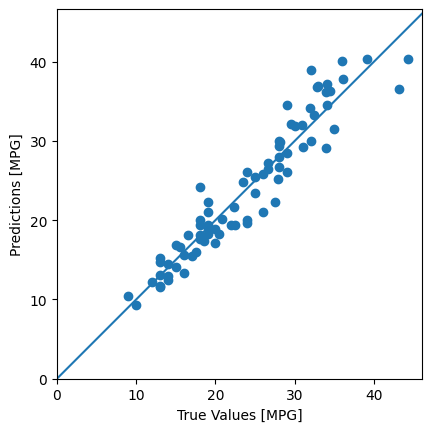

In [135]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

대부분의 오차가 0을 중심으로 대칭적인 분포를 보이고 있습니다. 이는 모델이 대체로 균형 잡힌 예측을 수행했다는 것을 의미합니다. 대부분의 데이터는 약 ±4 MPG 이내에 위치하며, 이는 비교적 양호한 예측 성능을 보여줍니다. 하지만 일부 데이터에서는 ±6 MPG 이상의 큰 오차가 발생했는데, 이는 모델이 특정 샘플에서 다소 부정확한 예측을 했음을 나타냅니다. 이러한 특이점은 데이터의 이상치나 모델의 한계로 인한 것일 수 있습니다.

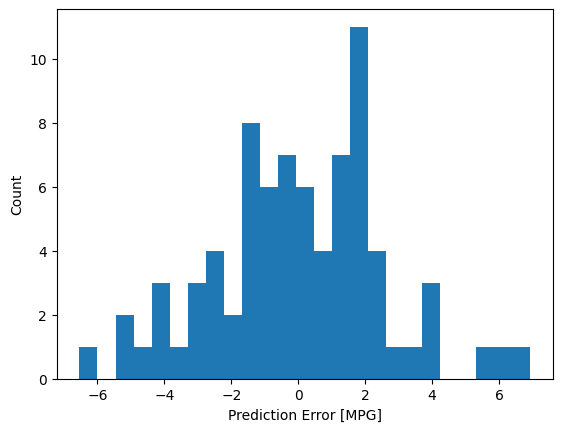

In [136]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

gpt사용: 결측치 처리, early stop

https://chatgpt.com/c/6757ced6-a74c-8004-b0df-ed687378a272

import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

dataset_path = keras.utils.get_file(
    "auto-mpg.data",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
)

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']   여기 결측치 처리하는법

ChatGPT의 말:
ChatGPT
auto-mpg.data 파일에서 결측치를 처리하는 방법은 데이터를 읽어들일 때 특정 값(예: ?)을 결측치로 간주하고, 이를 제거하거나 적절히 대체하는 것입니다. 아래는 결측치를 처리하는 단계별 방법입니다.

1. 데이터 로드와 결측치 처리 코드
python
코드 복사
# 데이터 로드
dataset_path = keras.utils.get_file(
    "auto-mpg.data",
    "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
)

# 데이터 불러오기
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(
    dataset_path,
    names=column_names,
    na_values="?",  # '?'를 결측치로 간주
    comment='\t',  # 주석 제거
    sep=" ",       # 공백으로 구분
    skipinitialspace=True  # 초기 공백 무시
)

# 결측치 확인
print(raw_dataset.isnull().sum())

# 결측치 제거
dataset = raw_dataset.dropna()
2. 결측치 처리 과정 설명
na_values="?": ?를 결측치로 간주하도록 지정합니다.
데이터 파일에서 ?는 값이 없는 경우를 나타냅니다.
dropna(): 결측치가 포함된 행을 제거합니다.
dropna()를 사용하여 결측치가 있는 모든 행을 삭제합니다.
결측치 확인: isnull().sum()으로 각 열에 포함된 결측치 개수를 확인합니다.
이를 통해 데이터의 결측치가 제대로 처리되었는지 점검합니다.
3. 대체 처리 방법 (선택 사항)
결측치를 제거하지 않고 특정 값으로 대체하려면 fillna()를 사용합니다.

평균값으로 대체
python
코드 복사
dataset['Horsepower'] = dataset['Horsepower'].fillna(dataset['Horsepower'].mean())
중간값으로 대체
python
코드 복사
dataset['Horsepower'] = dataset['Horsepower'].fillna(dataset['Horsepower'].median())
특정 값으로 대체
python
코드 복사
dataset['Horsepower'] = dataset['Horsepower'].fillna(0)
이 코드는 결측치 처리를 효율적으로 수행하며, dropna() 또는 fillna()를 사용하여 데이터의 무결성을 유지합니다. 필요하면 특정 방법을 선택해서 적용하세요! 😊

에포크 반복 미리 종료되게 하는법

에포크 반복을 미리 종료하려면 조기 종료(Early Stopping) 기법을 사용하면 됩니다. TensorFlow/Keras에서 제공하는 EarlyStopping 콜백을 활용하면, 모델 학습 중 검증 손실(val_loss) 또는 다른 평가 지표가 개선되지 않을 때 학습을 자동으로 중단할 수 있습니다.

조기 종료 구현 방법
1. EarlyStopping 콜백 사용
python
코드 복사
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 정의
early_stop = EarlyStopping(
    monitor='val_loss',     # 모니터링할 지표 (검증 손실)
    patience=10,            # 성능 개선 없이 기다릴 에포크 수
    restore_best_weights=True  # 최적의 가중치 복원
)

# 모델 학습
history = model.fit(
    normed_train_data, train_labels,
    epochs=1000,               # 최대 반복 에포크
    validation_split=0.2,      # 검증 데이터 비율
    verbose=1,
    callbacks=[early_stop]     # EarlyStopping 콜백 추가
)
코드 설명
monitor='val_loss': 검증 손실(val_loss)을 모니터링하여 종료 조건을 설정합니다.

다른 지표를 기준으로 종료하고 싶다면, 예를 들어 검증 MSE(val_mse)를 모니터링하려면 monitor='val_mse'로 변경합니다.
patience=10: 학습이 10번의 에포크 동안 개선되지 않으면 학습을 중단합니다.

patience 값을 줄이면 더 빠르게 종료되며, 모델이 학습할 충분한 기회를 주려면 값을 더 늘릴 수도 있습니다.
restore_best_weights=True: 학습 종료 시, 최적의 성능을 보였던 시점의 가중치로 복원합니다.

callbacks=[early_stop]: model.fit 함수에서 callbacks 인자를 통해 EarlyStopping을 추가합니다.

조기 종료 동작 예시
에포크가 1000번으로 설정되었더라도, 검증 손실(val_loss)이 10번 연속 개선되지 않으면 학습이 자동으로 종료됩니다.
학습 로그에서 종료 시점에 대한 메시지가 출력됩니다:
yaml
코드 복사
Epoch 120: early stopping
응용
모니터링 지표 변경:

python
코드 복사
early_stop = EarlyStopping(monitor='val_mse', patience=5)
빠른 실험용으로 patience 줄이기:

python
코드 복사
early_stop = EarlyStopping(monitor='val_loss', patience=3)
조기 종료를 통해 학습 시간을 줄이고 과적합을 방지할 수 있으니, 원하는 지표와 patience 값을 설정해 활용하면 됩니다! 😊

학생들이 문제중심학습 방식으로 해결할 수 있는 다양한 주제와 데이터셋을 다음과 같이 제안합니다. 이 목록은 Dense Layer를 사용하는 인공신경망과 의사결정나무를 사용하는 문제를 포함하며, 자동차 연비 예측도 포함되어 있습니다.
Dense Layer를 사용하는 인공신경망
손글씨 숫자 인식
데이터셋: MNIST
데이터 링크: MNIST Dataset
패션 아이템 분류
데이터셋: Fashion MNIST
데이터 링크: Fashion MNIST Dataset
의료 이미지 분류
데이터셋: Chest X-ray Images
데이터 링크: Chest X-ray Dataset
음성 감정 인식
데이터셋: RAVDESS
데이터 링크: RAVDESS Dataset
자동차 연비 예측
데이터셋: Auto MPG
데이터 링크: Auto MPG Dataset
의사결정나무를 사용하는 문제
아이리스 꽃 분류
데이터셋: Iris
데이터 링크: Iris Dataset
타이타닉 생존자 예측
데이터셋: Titanic
데이터 링크: Titanic Dataset
소매업 매출 예측
데이터셋: Online Retail
데이터 링크: Online Retail Dataset
신용카드 사기 탐지
데이터셋: Credit Card Fraud Detection
데이터 링크: Credit Card Fraud Detection Dataset
주택 가격 예측
데이터셋: Boston Housing
데이터 링크: Boston Housing Dataset
이러한 문제들은 학생들이 다양한 머신러닝 기법을 적용하고, 실제 데이터를 사용하여 모델을 구축하고 평가하는 데 유익한 경험을 제공할 것입니다.